In [31]:
import scipy.integrate as integrate 
import math
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as integrate 
import cmath 
from scipy import optimize
from scipy.misc import derivative

from decimal import Decimal
from decimal import *
getcontext().prec = 64


In [32]:
 #Defining the (exact) Bosonic and fermionic thermal functions to be used it the effective potential
 #integral allows imaginary masses but only returns the real parts since this is the only thing we are interested in 
 #for the effective potential.    
    
def Jb(m,T):
    
    def integrand(k,m,T):    
        return k**2*np.log(1 - np.exp(-np.sqrt(k**2 + (m/T)**2)))
        
    return T**4/(2*np.pi**2)*integrate.quad(integrand, 0, np.inf, args = (m,T))[0]   

def Jf(m,T):
    
    def integrand(k,m, T):    
        return k**2*np.log(1 + np.exp(-np.sqrt(k**2 + (m/T)**2)))
                                  
    return T**4/(2*np.pi**2)*integrate.quad(integrand, 0, np.inf, args = (m,T))[0]
        


In [39]:
# Parameters and effective masses to be used in the effective potential
# constants of higgs tree level potential
mu = 5000
lam = 0.01
c6 = -1/10000
Lam = 246

#yukawa coupling constant of fermion f 
y_f = 0.99                                          #(for the top quark)

#EW - sector coupling constants g (SU(2)_L) and g_p (U(1)_Y) 
g = 0.65
g_p = 0.36
eps = 0.00001


# Effective mass of fermion f acquired through yukawa coupling w/ the Higgs
def m_f(phi):
    return y_f**2/2*phi**2 + eps

# W and Z boson masses
def m_W(phi):
    return (g**2/4)*phi**2 + eps

def m_Z(phi):
    return (g**2 + g_p**2)*phi**2/4 + eps

# Higgs and Goldstone masses
def m_h(phi):                                               
    return 3*lam*phi**2 - mu**2 - (15/4)*c6*phi**4 + eps

#m_h 0 at h_min = (2/5)*(lam/c6)*(1 - np.sqrt(1-5/3*c6*(mu**2)/lam**2))

def m_g(phi):
    return lam*phi**2 - mu**2 - (3/4)*c6*phi**4 + eps


In [ ]:
Lam = 246     # regulator/Cutoff(?)

#1-loop effective potential
def v_eff(phi,T):
    return np.real(-(mu**2)/2*phi**2 + (lam/4)*phi**4 - (c6/8)*phi**6
            + m_h(phi)**2/(64*np.pi**2)*(cmath.log(m_h(phi)/Lam) - 3/2) + Jb(cmath.sqrt(m_h(phi)),T)
            + 3*m_g(phi)**2/(64*np.pi**2)*(cmath.log(m_g(phi)/Lam) - 3/2) + 3*Jb(cmath.sqrt(m_g(phi)),T)
            + 3*m_Z(phi)**2/(64*np.pi**2)*(cmath.log(m_Z(phi)/Lam) - 5/6) + 3*Jb(cmath.sqrt(m_Z(phi)),T)
            + 6*m_W(phi)**2/(64*np.pi**2)*(cmath.log(m_W(phi)/Lam) - 5/6) + 6*Jb(cmath.sqrt(m_W(phi)),T)    
            - 12*m_f(phi)**2/(64*np.pi**2)*(cmath.log(m_f(phi)/Lam) - 3/2) - 12*Jf(cmath.sqrt(m_f(phi)),T)
           )/(Lam**4)


vecv_eff = np.vectorize(v_eff)


phi = np.linspace(-750,750,500)
T = 2030
arrv_eff = vecv_eff(phi,T) - v_eff(0,T)


plt.plot(phi, arrv_eff)
plt.xlabel('$\phi$')
plt.ylabel('$V_{eff}(\phi)$')
plt.title('1-loop effective potential at T = %1.0f'  % T)

#Tree level min
phi_min = ((2*lam)/(3*c6))*(1 - np.sqrt(1 - (3*c6*mu**2)/(lam**2)))


In [49]:
#Finding the critical temperature where the effective potential acquires the same value at both minima


# defining a recursive method for finding the critical temperature up to some tolerance which is chosen when calling the 
# function. The function requires a span/interval of temperaturs to as to where it  
#
# The effective potential is normalized so that the first minimum is at v_eff(phi = 0) regadless of T   
# 
#
#
#

def find_t_crit(t_span, tolerance):
    T = np.mean(t_span)
    
    def v_eff_T(phi):
        T = np.mean(t_span)
        return v_eff(phi,T) - v_eff(0,T)
    min2 = v_eff_T(optimize.fmin(v_eff_T, 600)[0])
    
    
    if abs(min2) < tolerance:
        return T
    elif min2 > tolerance:                                      
        return find_t_crit([t_span[0], np.mean(t_span)],tolerance)
    elif min2 < -tolerance:
        return find_t_crit([np.mean(t_span), t_span[1]],tolerance)    
    
    return T


t_span = [1000, 2030]
tolerance = 1

t_c = find_t_crit(t_span, tolerance)   
print(t_c)

Optimization terminated successfully.
         Current function value: -4263.603935
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -1576.081211
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 289.997827
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -692.040126
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -213.701826
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 34.923126
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -90.188693
         Iterations: 21
         Function evaluations: 42
Optimization te

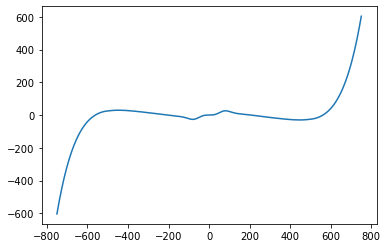

In [52]:
# Finding the bounce action.  
tn = 1500

def v_eff_tn(phi):
    return np.vectorize(v_eff)(phi,tn) - np.vectorize(v_eff)(0,tn)

arrv_eff = vecv_eff(phi,tn) - v_eff(0,tn)

def v_p(phi):
    return derivative(v_eff_tn, phi, dx = 0.00001, order=5)

def f(t,y):    
    A = y[0]
    B = y[1]
    
    dA_dt = B
    dB_dt = v_p(A) - (2/t)*B                               
                                                            
    return np.array([dA_dt, dB_dt])


plt.plot(phi, v_p(phi))

In [53]:
# finding the phi values of symmetric and broken phases to be later used in overshoot/undershoot method.
# the symmetric phase at phi ~ 5.87 very hard to reach since the potenial get's very flat around it. 
# it should suffice to use the 7.57 one instead (within the tolerance)

#finding phi within tolerance to use as stop condition for overshoot/undershoot
symm_vac = optimize.fmin(v_eff_tn, 0)[0]

#finding phi within tolerance to use as stop condition for overshoot/undershoot
x = np.linspace(0,10,100)

tol1 = 2e-2
max_min = x[np.max(np.where(np.abs(v_eff_tn(x) - (-0.033533))<tol1))]
broken_vac = optimize.fmin(v_eff_tn, 600)[0]

tol =  max_min - symm_vac

print(tol)
print(symm_vac)
print(broken_vac)

Optimization terminated successfully.
         Current function value: -0.073558
         Iterations: 30
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -4383.632709
         Iterations: 21
         Function evaluations: 42
2.437086489898981
6.552812500000009
560.9560203552246


In [59]:
# Full on over/undershoot implementation to find the bounce solution. Works in the same way as finding the critical temp
# algorithm get's stuck somtetimes due to np.mean not being sensitive enough(?).



print(broken_vac)
print(np.array([symm_vac - tol, symm_vac + tol]), '\n')

def over_undershoot(init_span, tol, max_i, iter = None):
    
    if iter is None:
        iter = 0
        
    iter +=1    
    
    if iter == max_i:
        print('arrived at max iterations')
        print('final span: ', init_span)
        
    else:
        t_span = np.array([eps,120])
        times  = np.linspace(t_span[0], t_span[1], 1000) 
        init = np.mean(init_span)
        y0 = np.array([init, 0])
    
        soln = solve_ivp(f, t_span, y0, t_eval = times)
        print(soln.message)   
    
    
        t = soln.t
        phi_b = soln.y[0] 
    
    
        if np.abs(phi_b[-1] - symm_vac) <= tol:
            print('Found it! y0=', init)
            print('And it ended at:', phi_b[-1])
            return phi_b, t, soln.y[1]
    
        elif phi_b[-1] < symm_vac - tol or phi_b[-1] > init:
            #condition for rolling down to the left towards phi = -inf &
            #condition for rolling down to the right towards phi = +inf  
            #This means we are too far high up in the span and initial condition is to high.
        
            print('iteration: ', iter)
            print('y0 = ', init)
            print('overshoot')
            print('final value of the solution:', phi_b[-1])
            print('\n')
            return over_undershoot([init_span[0], init], tol, max_i, iter)
    
        else:  #phi_b[-1] > symm_vac + tol and phi_b[-1] < init:
            # All other scenarios are undershoot.
            # The initial value is to low need to look higher up in the interval for the correct initial value
            
            print('iteration: ', iter)
            print('y0 = ',  init)
            print('undershoot')
            print('smallest value of the solution:' , np.min(phi_b))
            print('And it ended at', phi_b[-1])
            print('\n')
            return over_undershoot([init, init_span[1]],tol, max_i, iter)
                
              
init_span = np.array([broken_vac-200, broken_vac])     
                                                      
phi_b , r , phi_dot = over_undershoot(init_span, tol, 100)


plt.plot(r, phi_b)

560.9560203552246
[4.11572601 8.98989899] 

The solver successfully reached the end of the integration interval.
iteration:  1
y0 =  460.9560203552246
undershoot
smallest value of the solution: 145.1238525128894
And it ended at 206.5772822891414


The solver successfully reached the end of the integration interval.
iteration:  2
y0 =  510.9560203552246
undershoot
smallest value of the solution: 126.92941996414814
And it ended at 207.81280394514928


The solver successfully reached the end of the integration interval.
iteration:  3
y0 =  535.9560203552246
undershoot
smallest value of the solution: 114.86254108261397
And it ended at 209.31737867909715


The solver successfully reached the end of the integration interval.
iteration:  4
y0 =  548.4560203552246
undershoot
smallest value of the solution: 104.01998723253752
And it ended at 211.7463632152859


The solver successfully reached the end of the integration interval.
iteration:  5
y0 =  554.7060203552246
undershoot
smallest value of

The solver successfully reached the end of the integration interval.
iteration:  46
y0 =  560.9195914888215
overshoot
final value of the solution: -249.59069863656245


The solver successfully reached the end of the integration interval.
iteration:  47
y0 =  560.9195914888201
overshoot
final value of the solution: -221.0271679761037


The solver successfully reached the end of the integration interval.
iteration:  48
y0 =  560.9195914888194
overshoot
final value of the solution: -248.4829435307971


The solver successfully reached the end of the integration interval.
iteration:  49
y0 =  560.919591488819
overshoot
final value of the solution: -247.17561338600046


The solver successfully reached the end of the integration interval.
iteration:  50
y0 =  560.9195914888189
overshoot
final value of the solution: -211.39093471311784


The solver successfully reached the end of the integration interval.
iteration:  51
y0 =  560.9195914888188
overshoot
final value of the solution: -195.077042

The solver successfully reached the end of the integration interval.
iteration:  87
y0 =  560.9195914888187
undershoot
smallest value of the solution: 12.513716891318353
And it ended at 153.16571055884376


The solver successfully reached the end of the integration interval.
iteration:  88
y0 =  560.9195914888187
undershoot
smallest value of the solution: 12.513716891318353
And it ended at 153.16571055884376


The solver successfully reached the end of the integration interval.
iteration:  89
y0 =  560.9195914888187
undershoot
smallest value of the solution: 12.513716891318353
And it ended at 153.16571055884376


The solver successfully reached the end of the integration interval.
iteration:  90
y0 =  560.9195914888187
undershoot
smallest value of the solution: 12.513716891318353
And it ended at 153.16571055884376


The solver successfully reached the end of the integration interval.
iteration:  91
y0 =  560.9195914888187
undershoot
smallest value of the solution: 12.513716891318353
An

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
t_span = np.array([eps, 55])

times  = np.linspace(t_span[0], t_span[1], 1000) 

y0 = np.array([broken_vac, 0])


soln = solve_ivp(f, t_span, y0, t_eval=times) 

r = soln.t
phi_b = soln.y[0]
dphi_b = soln.y[1]

print(phi_b[-1]) 
print(min(phi_b))

plt.subplot(1,2,1)
plt.plot(r,phi_b) 

plt.subplot(1,2,2)
plt.plot(r,dphi_b)
plt.tight_layout() 